In [1]:
import os
import time
import math
import copy
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import random
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# Path to your DTD dataset (downloaded and extracted)

DATASET_PATH = f"{os.getcwd()}/ambient-cg-images"
DATASET_PATH

'C:\\Projects\\Texture-SuperResolution/ambient-cg-images'

In [3]:
# -----------------------------
# 🔹 Preprocessing Function
# -----------------------------
IMAGE_LIMIT = 100

def load_dtd_dataset(root_dir, scale_factor=2, patch_size=64, test_size=0.2):
    """
    Loads DTD dataset and creates LR-HR pairs as numpy arrays.
    """
    image_files = []
    counter = 0
    for root, _, files in os.walk(root_dir):
        if counter > IMAGE_LIMIT:
            break
        for f in files:
            if counter > IMAGE_LIMIT:
                break
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, f))
                counter += 1
                
    to_tensor = transforms.ToTensor()
    X, Y = [], []

    for img_path in image_files:
        hr_img = Image.open(img_path).convert("RGB")
        width, height = hr_img.size

        # Ensure patch fits
        if width < patch_size or height < patch_size:
            hr_img = hr_img.resize((patch_size, patch_size), Image.BICUBIC)
        else:
            # Random crop
            left = np.random.randint(0, width - patch_size + 1)
            top = np.random.randint(0, height - patch_size + 1)
            hr_img = hr_img.crop((left, top, left + patch_size, top + patch_size))

        # Create low-res version
        lr_size = (patch_size // scale_factor, patch_size // scale_factor)
        lr_img = hr_img.resize(lr_size, Image.BICUBIC)
        lr_img = lr_img.resize((patch_size, patch_size), Image.BICUBIC)

        # Convert to tensors (C,H,W) and append
        X.append(to_tensor(lr_img).numpy())
        Y.append(to_tensor(hr_img).numpy())

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    # Train/val split
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)

    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = load_dtd_dataset(DATASET_PATH, scale_factor=3, patch_size=64)

C:\Users\neelr\AppData\Roaming\Python\Python313\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (150994944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
class TextureDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)  # convert to torch.Tensor
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [5]:
train_dataset = TextureDataset(X_train, Y_train)
val_dataset = TextureDataset(X_val, Y_val)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

# Test one sample
lr, hr = train_dataset[56]
print("LR shape:", lr.shape, "HR shape:", hr.shape)

Train samples: 80
Val samples: 21
LR shape: torch.Size([3, 64, 64]) HR shape: torch.Size([3, 64, 64])


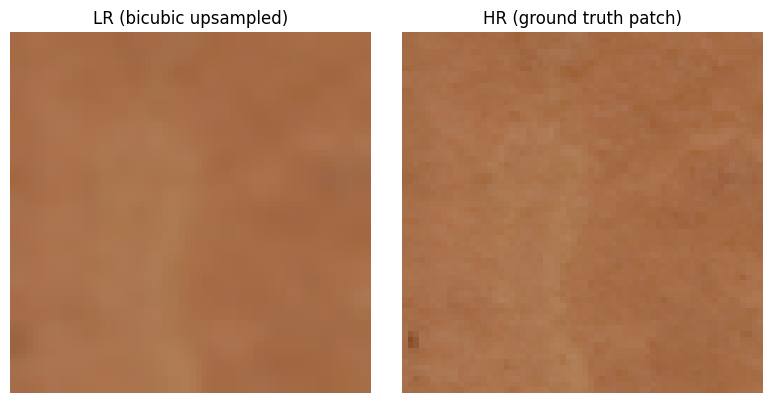

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.transpose(lr.numpy(), (1, 2, 0)))
axes[0].set_title("LR (bicubic upsampled)")
axes[0].axis("off")
axes[1].imshow(np.transpose(hr.numpy(), (1, 2, 0)))
axes[1].set_title("HR (ground truth patch)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [7]:
BATCH_SIZE   = 16
NUM_EPOCHS   = 400
LR           = 1e-4
STEP_EVERY   = 15
GAMMA        = 0.5
NUM_WORKERS  = 0
PIN_MEMORY   = False

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [9]:
from model import SRCNN

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


model = SRCNN(num_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.conv3.parameters(), 'lr': LR}
], lr=LR)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % BATCH_SIZE)) as t:
        t.set_description('epoch: {}/{}'.format(epoch, NUM_EPOCHS - 1))

        for data in train_loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    model.eval()
    epoch_psnr = AverageMeter()

    for data in val_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs).clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join("./", 'best.pth'))

epoch: 0/399:   0%|                                                                             | 0/80 [00:00<?, ?it/s]C:\Users\neelr\AppData\Local\Temp\ipykernel_34688\1108744689.py:98: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  epoch_losses.update(loss.item(), len(inputs))
epoch: 0/399: 100%|████████████████████████████████████████████████████| 80/80 [00:00<00:00, 404.47it/s, loss=0.207782]


eval psnr: 7.13


epoch: 1/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5472.91it/s, loss=0.153755]


eval psnr: 9.02


epoch: 2/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5206.92it/s, loss=0.082411]


eval psnr: 13.46


epoch: 3/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5438.67it/s, loss=0.026028]


eval psnr: 15.82


epoch: 4/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5493.79it/s, loss=0.028825]


eval psnr: 15.12


epoch: 5/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5463.11it/s, loss=0.020648]


eval psnr: 17.66


epoch: 6/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 4758.48it/s, loss=0.015401]


eval psnr: 17.31


epoch: 7/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 4578.62it/s, loss=0.015146]


eval psnr: 18.46


epoch: 8/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5205.30it/s, loss=0.012602]


eval psnr: 18.50


epoch: 9/399: 100%|███████████████████████████████████████████████████| 80/80 [00:00<00:00, 5284.50it/s, loss=0.011436]


eval psnr: 19.11


epoch: 10/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5332.36it/s, loss=0.010280]

eval psnr: 19.68



epoch: 11/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5483.29it/s, loss=0.009072]


eval psnr: 20.10


epoch: 12/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5617.03it/s, loss=0.008237]


eval psnr: 20.52


epoch: 13/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5611.39it/s, loss=0.007458]


eval psnr: 21.01


epoch: 14/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5336.09it/s, loss=0.006622]


eval psnr: 21.51


epoch: 15/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5331.60it/s, loss=0.005997]


eval psnr: 21.92


epoch: 16/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5418.21it/s, loss=0.005448]


eval psnr: 22.32


epoch: 17/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5215.34it/s, loss=0.005044]


eval psnr: 22.70


epoch: 18/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5413.49it/s, loss=0.004677]


eval psnr: 23.03


epoch: 19/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5272.04it/s, loss=0.004378]


eval psnr: 23.30


epoch: 20/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5315.22it/s, loss=0.004125]


eval psnr: 23.56


epoch: 21/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5711.10it/s, loss=0.003904]


eval psnr: 23.83


epoch: 22/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5242.96it/s, loss=0.003718]


eval psnr: 24.05


epoch: 23/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5058.86it/s, loss=0.003558]


eval psnr: 24.30


epoch: 24/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5235.35it/s, loss=0.003398]


eval psnr: 24.49


epoch: 25/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5097.21it/s, loss=0.003290]


eval psnr: 24.71


epoch: 26/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5428.55it/s, loss=0.003148]


eval psnr: 24.89


epoch: 27/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5771.22it/s, loss=0.003064]


eval psnr: 25.05


epoch: 28/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5457.07it/s, loss=0.002963]


eval psnr: 25.23


epoch: 29/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5650.99it/s, loss=0.002887]


eval psnr: 25.38


epoch: 30/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5394.52it/s, loss=0.002783]


eval psnr: 25.60


epoch: 31/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5034.27it/s, loss=0.002692]


eval psnr: 25.77


epoch: 32/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5449.80it/s, loss=0.002622]


eval psnr: 25.96


epoch: 33/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5413.58it/s, loss=0.002539]


eval psnr: 26.08


epoch: 34/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5742.87it/s, loss=0.002489]


eval psnr: 26.23


epoch: 35/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5766.85it/s, loss=0.002426]


eval psnr: 26.36


epoch: 36/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5601.55it/s, loss=0.002365]


eval psnr: 26.46


epoch: 37/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5175.44it/s, loss=0.002307]


eval psnr: 26.55


epoch: 38/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5719.77it/s, loss=0.002275]


eval psnr: 26.65


epoch: 39/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 4573.63it/s, loss=0.002242]


eval psnr: 26.75


epoch: 40/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5585.98it/s, loss=0.002192]


eval psnr: 26.80


epoch: 41/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5672.48it/s, loss=0.002152]


eval psnr: 26.89


epoch: 42/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5595.86it/s, loss=0.002112]


eval psnr: 26.96


epoch: 43/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5571.14it/s, loss=0.002086]


eval psnr: 27.03


epoch: 44/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5363.39it/s, loss=0.002055]


eval psnr: 27.10


epoch: 45/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5483.29it/s, loss=0.002026]


eval psnr: 27.15


epoch: 46/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5332.53it/s, loss=0.002000]


eval psnr: 27.20


epoch: 47/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5381.88it/s, loss=0.001975]


eval psnr: 27.25


epoch: 48/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5355.68it/s, loss=0.001956]


eval psnr: 27.31


epoch: 49/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 4995.00it/s, loss=0.001931]


eval psnr: 27.35


epoch: 50/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5653.56it/s, loss=0.001916]


eval psnr: 27.41


epoch: 51/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5378.17it/s, loss=0.001896]


eval psnr: 27.44


epoch: 52/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5644.24it/s, loss=0.001875]


eval psnr: 27.48


epoch: 53/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5815.43it/s, loss=0.001856]


eval psnr: 27.52


epoch: 54/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5447.50it/s, loss=0.001837]


eval psnr: 27.56


epoch: 55/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5396.25it/s, loss=0.001821]


eval psnr: 27.61


epoch: 56/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5682.47it/s, loss=0.001804]


eval psnr: 27.64


epoch: 57/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5239.85it/s, loss=0.001791]


eval psnr: 27.67


epoch: 58/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5453.61it/s, loss=0.001779]


eval psnr: 27.69


epoch: 59/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5611.20it/s, loss=0.001767]


eval psnr: 27.71


epoch: 60/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5434.88it/s, loss=0.001754]


eval psnr: 27.75


epoch: 61/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5735.11it/s, loss=0.001743]


eval psnr: 27.79


epoch: 62/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5523.00it/s, loss=0.001731]


eval psnr: 27.81


epoch: 63/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5314.96it/s, loss=0.001722]


eval psnr: 27.85


epoch: 64/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5487.32it/s, loss=0.001713]


eval psnr: 27.88


epoch: 65/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5709.25it/s, loss=0.001700]


eval psnr: 27.91


epoch: 66/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5578.37it/s, loss=0.001688]


eval psnr: 27.93


epoch: 67/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5693.27it/s, loss=0.001679]


eval psnr: 27.95


epoch: 68/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5537.67it/s, loss=0.001670]


eval psnr: 27.97


epoch: 69/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5501.63it/s, loss=0.001662]


eval psnr: 28.00


epoch: 70/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5284.75it/s, loss=0.001654]


eval psnr: 28.02


epoch: 71/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5310.84it/s, loss=0.001646]


eval psnr: 28.02


epoch: 72/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5417.42it/s, loss=0.001640]


eval psnr: 28.05


epoch: 73/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5288.58it/s, loss=0.001631]


eval psnr: 28.09


epoch: 74/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5534.20it/s, loss=0.001623]


eval psnr: 28.09


epoch: 75/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5616.09it/s, loss=0.001616]


eval psnr: 28.12


epoch: 76/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5667.12it/s, loss=0.001616]


eval psnr: 28.11


epoch: 77/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5498.38it/s, loss=0.001609]


eval psnr: 28.15


epoch: 78/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5372.06it/s, loss=0.001599]


eval psnr: 28.17


epoch: 79/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5559.88it/s, loss=0.001596]


eval psnr: 28.11


epoch: 80/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5430.13it/s, loss=0.001598]


eval psnr: 28.19


epoch: 81/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5592.59it/s, loss=0.001583]


eval psnr: 28.21


epoch: 82/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5590.45it/s, loss=0.001580]


eval psnr: 28.21


epoch: 83/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5845.41it/s, loss=0.001581]


eval psnr: 28.27


epoch: 84/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5265.51it/s, loss=0.001576]


eval psnr: 28.28


epoch: 85/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5397.81it/s, loss=0.001559]


eval psnr: 28.30


epoch: 86/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5541.15it/s, loss=0.001553]


eval psnr: 28.30


epoch: 87/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5772.81it/s, loss=0.001548]


eval psnr: 28.32


epoch: 88/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5582.45it/s, loss=0.001543]


eval psnr: 28.34


epoch: 89/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5534.48it/s, loss=0.001540]


eval psnr: 28.36


epoch: 90/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5608.20it/s, loss=0.001535]


eval psnr: 28.38


epoch: 91/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5788.84it/s, loss=0.001530]


eval psnr: 28.38


epoch: 92/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 4575.94it/s, loss=0.001526]


eval psnr: 28.40


epoch: 93/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5352.78it/s, loss=0.001519]


eval psnr: 28.42


epoch: 94/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5722.79it/s, loss=0.001515]


eval psnr: 28.43


epoch: 95/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5711.49it/s, loss=0.001511]


eval psnr: 28.43


epoch: 96/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5294.42it/s, loss=0.001507]


eval psnr: 28.46


epoch: 97/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5680.84it/s, loss=0.001502]


eval psnr: 28.47


epoch: 98/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5673.06it/s, loss=0.001499]


eval psnr: 28.48


epoch: 99/399: 100%|██████████████████████████████████████████████████| 80/80 [00:00<00:00, 5463.29it/s, loss=0.001496]


eval psnr: 28.50


epoch: 100/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5501.99it/s, loss=0.001492]


eval psnr: 28.51


epoch: 101/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5408.25it/s, loss=0.001487]


eval psnr: 28.53


epoch: 102/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5069.18it/s, loss=0.001483]


eval psnr: 28.54


epoch: 103/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5860.22it/s, loss=0.001479]


eval psnr: 28.55


epoch: 104/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5318.59it/s, loss=0.001476]


eval psnr: 28.57


epoch: 105/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5369.91it/s, loss=0.001472]


eval psnr: 28.58


epoch: 106/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5613.64it/s, loss=0.001469]


eval psnr: 28.59


epoch: 107/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5419.87it/s, loss=0.001466]


eval psnr: 28.60


epoch: 108/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5580.59it/s, loss=0.001462]


eval psnr: 28.62


epoch: 109/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5536.49it/s, loss=0.001458]


eval psnr: 28.63


epoch: 110/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5616.65it/s, loss=0.001457]


eval psnr: 28.63


epoch: 111/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5914.34it/s, loss=0.001455]


eval psnr: 28.64


epoch: 112/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5608.20it/s, loss=0.001451]


eval psnr: 28.64


epoch: 113/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5396.08it/s, loss=0.001452]


eval psnr: 28.66


epoch: 114/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5465.51it/s, loss=0.001446]


eval psnr: 28.66


epoch: 115/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5477.11it/s, loss=0.001443]


eval psnr: 28.66


epoch: 116/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5607.83it/s, loss=0.001449]


eval psnr: 28.63


epoch: 117/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5387.59it/s, loss=0.001441]


eval psnr: 28.69


epoch: 118/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5629.37it/s, loss=0.001435]


eval psnr: 28.72


epoch: 119/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5384.73it/s, loss=0.001430]


eval psnr: 28.72


epoch: 120/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5376.28it/s, loss=0.001428]


eval psnr: 28.74


epoch: 121/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5482.30it/s, loss=0.001425]


eval psnr: 28.74


epoch: 122/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5539.32it/s, loss=0.001422]


eval psnr: 28.75


epoch: 123/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4702.73it/s, loss=0.001419]


eval psnr: 28.76


epoch: 124/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4715.95it/s, loss=0.001419]


eval psnr: 28.76


epoch: 125/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5453.43it/s, loss=0.001419]


eval psnr: 28.78


epoch: 126/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5354.32it/s, loss=0.001413]


eval psnr: 28.78


epoch: 127/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5591.57it/s, loss=0.001411]


eval psnr: 28.80


epoch: 128/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5595.76it/s, loss=0.001409]


eval psnr: 28.78


epoch: 129/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5366.91it/s, loss=0.001410]


eval psnr: 28.82


epoch: 130/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5070.94it/s, loss=0.001414]


eval psnr: 28.70


epoch: 131/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5779.87it/s, loss=0.001429]


eval psnr: 28.63


epoch: 132/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5583.94it/s, loss=0.001432]


eval psnr: 28.82


epoch: 133/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5466.58it/s, loss=0.001428]


eval psnr: 28.74


epoch: 134/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5478.90it/s, loss=0.001423]


eval psnr: 28.78


epoch: 135/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5582.08it/s, loss=0.001431]


eval psnr: 28.59


epoch: 136/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5210.64it/s, loss=0.001431]


eval psnr: 28.65


epoch: 137/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5757.06it/s, loss=0.001432]


eval psnr: 28.88


epoch: 138/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5567.81it/s, loss=0.001428]


eval psnr: 28.74


epoch: 139/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5510.39it/s, loss=0.001429]


eval psnr: 28.61


epoch: 140/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5523.91it/s, loss=0.001445]


eval psnr: 28.85


epoch: 141/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5246.16it/s, loss=0.001413]


eval psnr: 28.80


epoch: 142/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5680.26it/s, loss=0.001397]


eval psnr: 28.85


epoch: 143/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5674.50it/s, loss=0.001392]


eval psnr: 28.91


epoch: 144/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4587.07it/s, loss=0.001381]


eval psnr: 28.93


epoch: 145/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5059.78it/s, loss=0.001377]


eval psnr: 28.91


epoch: 146/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5820.17it/s, loss=0.001377]


eval psnr: 28.93


epoch: 147/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5243.54it/s, loss=0.001376]


eval psnr: 28.94


epoch: 148/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5577.53it/s, loss=0.001372]


eval psnr: 28.94


epoch: 149/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5366.05it/s, loss=0.001371]


eval psnr: 28.94


epoch: 150/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5604.36it/s, loss=0.001370]


eval psnr: 28.95


epoch: 151/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5592.22it/s, loss=0.001368]


eval psnr: 28.96


epoch: 152/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5917.99it/s, loss=0.001366]


eval psnr: 28.97


epoch: 153/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5710.03it/s, loss=0.001364]


eval psnr: 28.98


epoch: 154/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5271.54it/s, loss=0.001363]


eval psnr: 28.98


epoch: 155/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5734.92it/s, loss=0.001363]


eval psnr: 28.98


epoch: 156/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5682.66it/s, loss=0.001361]


eval psnr: 28.99


epoch: 157/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5614.21it/s, loss=0.001361]


eval psnr: 29.00


epoch: 158/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5646.52it/s, loss=0.001360]


eval psnr: 28.99


epoch: 159/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5575.86it/s, loss=0.001359]


eval psnr: 29.00


epoch: 160/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5570.31it/s, loss=0.001357]


eval psnr: 29.00


epoch: 161/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5437.44it/s, loss=0.001356]


eval psnr: 29.01


epoch: 162/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5700.82it/s, loss=0.001353]


eval psnr: 29.02


epoch: 163/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5755.77it/s, loss=0.001352]


eval psnr: 29.02


epoch: 164/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5457.43it/s, loss=0.001350]


eval psnr: 29.03


epoch: 165/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5755.58it/s, loss=0.001349]


eval psnr: 29.03


epoch: 166/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5783.45it/s, loss=0.001348]

eval psnr: 29.04



epoch: 167/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5352.18it/s, loss=0.001346]


eval psnr: 29.04


epoch: 168/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5591.57it/s, loss=0.001346]


eval psnr: 29.05


epoch: 169/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5891.29it/s, loss=0.001345]


eval psnr: 29.05


epoch: 170/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5549.95it/s, loss=0.001344]


eval psnr: 29.06


epoch: 171/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5863.70it/s, loss=0.001342]

eval psnr: 29.06



epoch: 172/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5634.76it/s, loss=0.001341]

eval psnr: 29.07



epoch: 173/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5369.91it/s, loss=0.001340]

eval psnr: 29.08



epoch: 174/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5616.74it/s, loss=0.001338]


eval psnr: 29.08


epoch: 175/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5253.72it/s, loss=0.001337]


eval psnr: 29.08


epoch: 176/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5542.25it/s, loss=0.001336]


eval psnr: 29.08


epoch: 177/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5731.10it/s, loss=0.001335]


eval psnr: 29.09


epoch: 178/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5481.50it/s, loss=0.001335]


eval psnr: 29.09


epoch: 179/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5606.42it/s, loss=0.001336]

eval psnr: 29.10



epoch: 180/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5726.40it/s, loss=0.001335]

eval psnr: 29.10



epoch: 181/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5554.08it/s, loss=0.001336]


eval psnr: 29.10


epoch: 182/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5378.95it/s, loss=0.001339]


eval psnr: 29.11


epoch: 183/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5665.68it/s, loss=0.001334]


eval psnr: 29.10


epoch: 184/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5379.38it/s, loss=0.001331]


eval psnr: 29.12


epoch: 185/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5452.55it/s, loss=0.001327]


eval psnr: 29.13


epoch: 186/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5458.85it/s, loss=0.001324]


eval psnr: 29.13


epoch: 187/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5626.26it/s, loss=0.001323]


eval psnr: 29.14


epoch: 188/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5338.30it/s, loss=0.001323]


eval psnr: 29.13


epoch: 189/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5637.98it/s, loss=0.001323]


eval psnr: 29.14


epoch: 190/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5606.61it/s, loss=0.001322]


eval psnr: 29.12


epoch: 191/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5460.89it/s, loss=0.001321]


eval psnr: 29.14


epoch: 192/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5494.15it/s, loss=0.001320]


eval psnr: 29.07


epoch: 193/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5413.14it/s, loss=0.001329]


eval psnr: 29.02


epoch: 194/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5642.43it/s, loss=0.001342]


eval psnr: 28.92


epoch: 195/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5298.35it/s, loss=0.001341]


eval psnr: 29.09


epoch: 196/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5542.34it/s, loss=0.001340]


eval psnr: 28.95


epoch: 197/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5214.61it/s, loss=0.001350]


eval psnr: 29.14


epoch: 198/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4869.60it/s, loss=0.001323]


eval psnr: 29.17


epoch: 199/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5364.67it/s, loss=0.001315]


eval psnr: 29.17


epoch: 200/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5610.36it/s, loss=0.001313]


eval psnr: 29.17


epoch: 201/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5394.69it/s, loss=0.001311]


eval psnr: 29.18


epoch: 202/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5509.58it/s, loss=0.001310]


eval psnr: 29.19


epoch: 203/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5709.25it/s, loss=0.001309]


eval psnr: 29.19


epoch: 204/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5530.46it/s, loss=0.001308]


eval psnr: 29.20


epoch: 205/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5498.02it/s, loss=0.001306]


eval psnr: 29.20


epoch: 206/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5425.92it/s, loss=0.001305]


eval psnr: 29.21


epoch: 207/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5633.81it/s, loss=0.001305]


eval psnr: 29.22


epoch: 208/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5565.60it/s, loss=0.001304]


eval psnr: 29.21


epoch: 209/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5401.29it/s, loss=0.001304]


eval psnr: 29.22


epoch: 210/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5416.37it/s, loss=0.001303]


eval psnr: 29.22


epoch: 211/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5415.06it/s, loss=0.001301]


eval psnr: 29.23


epoch: 212/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5448.74it/s, loss=0.001301]


eval psnr: 29.22


epoch: 213/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5603.24it/s, loss=0.001301]


eval psnr: 29.24


epoch: 214/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5457.34it/s, loss=0.001301]


eval psnr: 29.24


epoch: 215/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5214.61it/s, loss=0.001299]


eval psnr: 29.24


epoch: 216/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5571.42it/s, loss=0.001297]


eval psnr: 29.25


epoch: 217/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5516.19it/s, loss=0.001297]


eval psnr: 29.25


epoch: 218/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5553.71it/s, loss=0.001296]


eval psnr: 29.25


epoch: 219/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5422.24it/s, loss=0.001296]


eval psnr: 29.25


epoch: 220/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5702.37it/s, loss=0.001295]


eval psnr: 29.25


epoch: 221/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5526.55it/s, loss=0.001294]


eval psnr: 29.25


epoch: 222/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5632.02it/s, loss=0.001293]


eval psnr: 29.26


epoch: 223/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5626.92it/s, loss=0.001293]


eval psnr: 29.26


epoch: 224/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5576.23it/s, loss=0.001292]


eval psnr: 29.27


epoch: 225/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5601.18it/s, loss=0.001290]


eval psnr: 29.27


epoch: 226/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5313.37it/s, loss=0.001289]


eval psnr: 29.28


epoch: 227/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5483.74it/s, loss=0.001290]


eval psnr: 29.28


epoch: 228/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5483.92it/s, loss=0.001288]


eval psnr: 29.27


epoch: 229/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5391.66it/s, loss=0.001289]


eval psnr: 29.28


epoch: 230/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5689.99it/s, loss=0.001288]


eval psnr: 29.28


epoch: 231/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5309.25it/s, loss=0.001286]


eval psnr: 29.29


epoch: 232/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5711.49it/s, loss=0.001285]


eval psnr: 29.29


epoch: 233/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5550.13it/s, loss=0.001285]


eval psnr: 29.29


epoch: 234/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5440.17it/s, loss=0.001285]


eval psnr: 29.28


epoch: 235/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5477.11it/s, loss=0.001285]


eval psnr: 29.30


epoch: 236/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5204.90it/s, loss=0.001284]


eval psnr: 29.30


epoch: 237/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5382.66it/s, loss=0.001283]


eval psnr: 29.30


epoch: 238/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5677.28it/s, loss=0.001282]


eval psnr: 29.31


epoch: 239/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5559.33it/s, loss=0.001282]


eval psnr: 29.29


epoch: 240/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5385.08it/s, loss=0.001284]


eval psnr: 29.29


epoch: 241/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5676.80it/s, loss=0.001285]


eval psnr: 29.32


epoch: 242/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5349.62it/s, loss=0.001281]


eval psnr: 29.32


epoch: 243/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5651.18it/s, loss=0.001280]


eval psnr: 29.30


epoch: 244/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5572.90it/s, loss=0.001281]


eval psnr: 29.33


epoch: 245/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5556.29it/s, loss=0.001278]


eval psnr: 29.34


epoch: 246/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5668.36it/s, loss=0.001278]


eval psnr: 29.33


epoch: 247/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5318.50it/s, loss=0.001277]


eval psnr: 29.33


epoch: 248/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5470.15it/s, loss=0.001277]


eval psnr: 29.34


epoch: 249/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5551.33it/s, loss=0.001275]


eval psnr: 29.34


epoch: 250/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5018.39it/s, loss=0.001275]


eval psnr: 29.32


epoch: 251/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4468.74it/s, loss=0.001275]


eval psnr: 29.35


epoch: 252/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4785.15it/s, loss=0.001273]


eval psnr: 29.35


epoch: 253/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5435.85it/s, loss=0.001272]


eval psnr: 29.36


epoch: 254/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5804.16it/s, loss=0.001271]


eval psnr: 29.36


epoch: 255/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5525.55it/s, loss=0.001272]


eval psnr: 29.36


epoch: 256/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5558.41it/s, loss=0.001272]


eval psnr: 29.35


epoch: 257/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5553.81it/s, loss=0.001271]


eval psnr: 29.36


epoch: 258/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5439.02it/s, loss=0.001270]


eval psnr: 29.36


epoch: 259/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5499.01it/s, loss=0.001270]


eval psnr: 29.36


epoch: 260/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5600.71it/s, loss=0.001269]


eval psnr: 29.37


epoch: 261/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5597.72it/s, loss=0.001268]


eval psnr: 29.38


epoch: 262/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5782.46it/s, loss=0.001267]


eval psnr: 29.37


epoch: 263/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5322.64it/s, loss=0.001267]


eval psnr: 29.38


epoch: 264/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5455.03it/s, loss=0.001267]


eval psnr: 29.38


epoch: 265/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5723.18it/s, loss=0.001266]


eval psnr: 29.37


epoch: 266/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5704.30it/s, loss=0.001268]


eval psnr: 29.35


epoch: 267/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5620.60it/s, loss=0.001269]


eval psnr: 29.37


epoch: 268/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5563.75it/s, loss=0.001265]


eval psnr: 29.39


epoch: 269/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5281.67it/s, loss=0.001263]


eval psnr: 29.40


epoch: 270/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5580.31it/s, loss=0.001262]


eval psnr: 29.39


epoch: 271/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5739.04it/s, loss=0.001262]


eval psnr: 29.39


epoch: 272/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5419.44it/s, loss=0.001262]


eval psnr: 29.39


epoch: 273/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5655.27it/s, loss=0.001262]


eval psnr: 29.40


epoch: 274/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5579.76it/s, loss=0.001260]


eval psnr: 29.40


epoch: 275/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5281.00it/s, loss=0.001261]


eval psnr: 29.41


epoch: 276/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5468.72it/s, loss=0.001261]


eval psnr: 29.40


epoch: 277/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5606.70it/s, loss=0.001259]


eval psnr: 29.39


epoch: 278/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5347.23it/s, loss=0.001260]


eval psnr: 29.41


epoch: 279/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5317.41it/s, loss=0.001258]


eval psnr: 29.42


epoch: 280/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5793.14it/s, loss=0.001258]


eval psnr: 29.42


epoch: 281/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5295.59it/s, loss=0.001257]


eval psnr: 29.41


epoch: 282/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5173.60it/s, loss=0.001256]


eval psnr: 29.42


epoch: 283/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5425.31it/s, loss=0.001256]


eval psnr: 29.42


epoch: 284/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5452.55it/s, loss=0.001260]


eval psnr: 29.42


epoch: 285/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5597.35it/s, loss=0.001260]


eval psnr: 29.39


epoch: 286/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5714.02it/s, loss=0.001263]


eval psnr: 29.41


epoch: 287/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5290.16it/s, loss=0.001265]


eval psnr: 29.44


epoch: 288/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5172.49it/s, loss=0.001271]


eval psnr: 29.33


epoch: 289/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5457.69it/s, loss=0.001287]


eval psnr: 29.35


epoch: 290/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5436.73it/s, loss=0.001295]


eval psnr: 29.27


epoch: 291/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5734.72it/s, loss=0.001286]


eval psnr: 29.06


epoch: 292/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5572.25it/s, loss=0.001321]


eval psnr: 28.98


epoch: 293/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5461.96it/s, loss=0.001294]


eval psnr: 29.32


epoch: 294/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5477.92it/s, loss=0.001275]


eval psnr: 29.30


epoch: 295/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5704.01it/s, loss=0.001272]

eval psnr: 29.29

epoch: 296/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5190.25it/s, loss=0.001283]


eval psnr: 29.10


epoch: 297/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5643.00it/s, loss=0.001297]


eval psnr: 29.07


epoch: 298/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5821.48it/s, loss=0.001314]


eval psnr: 29.32


epoch: 299/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5207.57it/s, loss=0.001277]


eval psnr: 29.45


epoch: 300/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5284.75it/s, loss=0.001266]


eval psnr: 29.41


epoch: 301/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5620.04it/s, loss=0.001259]


eval psnr: 29.41


epoch: 302/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5652.80it/s, loss=0.001257]


eval psnr: 29.40


epoch: 303/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5509.13it/s, loss=0.001254]


eval psnr: 29.43


epoch: 304/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5114.54it/s, loss=0.001252]


eval psnr: 29.44


epoch: 305/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4928.53it/s, loss=0.001250]


eval psnr: 29.46


epoch: 306/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5501.72it/s, loss=0.001246]


eval psnr: 29.46


epoch: 307/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5728.55it/s, loss=0.001246]


eval psnr: 29.46


epoch: 308/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5629.84it/s, loss=0.001247]


eval psnr: 29.46


epoch: 309/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5318.25it/s, loss=0.001248]


eval psnr: 29.47


epoch: 310/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5535.94it/s, loss=0.001245]


eval psnr: 29.47


epoch: 311/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5571.70it/s, loss=0.001244]


eval psnr: 29.48


epoch: 312/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5417.51it/s, loss=0.001243]


eval psnr: 29.48


epoch: 313/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5510.21it/s, loss=0.001243]


eval psnr: 29.48


epoch: 314/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5347.15it/s, loss=0.001242]


eval psnr: 29.49


epoch: 315/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5723.96it/s, loss=0.001242]


eval psnr: 29.48


epoch: 316/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5554.73it/s, loss=0.001242]


eval psnr: 29.49


epoch: 317/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5632.30it/s, loss=0.001242]


eval psnr: 29.48


epoch: 318/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5600.15it/s, loss=0.001242]


eval psnr: 29.48


epoch: 319/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5652.22it/s, loss=0.001241]


eval psnr: 29.49


epoch: 320/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5196.60it/s, loss=0.001241]


eval psnr: 29.49


epoch: 321/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5624.84it/s, loss=0.001240]


eval psnr: 29.49


epoch: 322/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5764.18it/s, loss=0.001240]


eval psnr: 29.49


epoch: 323/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5632.77it/s, loss=0.001240]


eval psnr: 29.50


epoch: 324/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5637.69it/s, loss=0.001241]


eval psnr: 29.50


epoch: 325/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5573.73it/s, loss=0.001240]


eval psnr: 29.50


epoch: 326/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5622.67it/s, loss=0.001241]


eval psnr: 29.50


epoch: 327/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5503.43it/s, loss=0.001240]


eval psnr: 29.48


epoch: 328/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5552.15it/s, loss=0.001242]


eval psnr: 29.47


epoch: 329/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5525.46it/s, loss=0.001242]


eval psnr: 29.50


epoch: 330/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5697.43it/s, loss=0.001240]


eval psnr: 29.51


epoch: 331/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4866.49it/s, loss=0.001237]


eval psnr: 29.50


epoch: 332/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5623.15it/s, loss=0.001237]


eval psnr: 29.51


epoch: 333/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5649.66it/s, loss=0.001236]


eval psnr: 29.52


epoch: 334/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5203.45it/s, loss=0.001238]


eval psnr: 29.51


epoch: 335/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5492.80it/s, loss=0.001236]


eval psnr: 29.50


epoch: 336/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5616.56it/s, loss=0.001239]


eval psnr: 29.51


epoch: 337/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5343.32it/s, loss=0.001239]


eval psnr: 29.46


epoch: 338/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5503.43it/s, loss=0.001244]


eval psnr: 29.51


epoch: 339/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5338.56it/s, loss=0.001235]


eval psnr: 29.53


epoch: 340/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5225.24it/s, loss=0.001233]


eval psnr: 29.52


epoch: 341/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5496.58it/s, loss=0.001233]


eval psnr: 29.52


epoch: 342/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5531.65it/s, loss=0.001233]


eval psnr: 29.53


epoch: 343/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5507.68it/s, loss=0.001233]


eval psnr: 29.52


epoch: 344/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5828.76it/s, loss=0.001233]


eval psnr: 29.52


epoch: 345/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5397.21it/s, loss=0.001232]


eval psnr: 29.53


epoch: 346/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5670.66it/s, loss=0.001231]


eval psnr: 29.54


epoch: 347/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5719.38it/s, loss=0.001231]


eval psnr: 29.54


epoch: 348/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5026.88it/s, loss=0.001230]


eval psnr: 29.54


epoch: 349/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5546.37it/s, loss=0.001230]


eval psnr: 29.54


epoch: 350/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5645.09it/s, loss=0.001230]


eval psnr: 29.54


epoch: 351/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5744.93it/s, loss=0.001230]


eval psnr: 29.53


epoch: 352/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5416.29it/s, loss=0.001232]


eval psnr: 29.51


epoch: 353/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5265.67it/s, loss=0.001233]


eval psnr: 29.54


epoch: 354/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5520.55it/s, loss=0.001230]


eval psnr: 29.54


epoch: 355/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5532.01it/s, loss=0.001230]


eval psnr: 29.55


epoch: 356/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5278.26it/s, loss=0.001228]


eval psnr: 29.55


epoch: 357/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4455.69it/s, loss=0.001228]


eval psnr: 29.54


epoch: 358/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5191.69it/s, loss=0.001232]


eval psnr: 29.55


epoch: 359/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5442.82it/s, loss=0.001238]


eval psnr: 29.56


epoch: 360/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4433.78it/s, loss=0.001237]


eval psnr: 29.42


epoch: 361/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 4899.17it/s, loss=0.001237]


eval psnr: 29.48


epoch: 362/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5409.04it/s, loss=0.001239]


eval psnr: 29.52


epoch: 363/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5203.53it/s, loss=0.001258]


eval psnr: 29.19


epoch: 364/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5477.74it/s, loss=0.001292]


eval psnr: 29.19


epoch: 365/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5327.62it/s, loss=0.001294]


eval psnr: 29.12


epoch: 366/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5407.99it/s, loss=0.001280]


eval psnr: 29.43


epoch: 367/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5743.65it/s, loss=0.001243]


eval psnr: 29.43


epoch: 368/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5601.46it/s, loss=0.001239]


eval psnr: 29.54


epoch: 369/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5574.10it/s, loss=0.001230]


eval psnr: 29.57


epoch: 370/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5527.28it/s, loss=0.001226]


eval psnr: 29.57


epoch: 371/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5254.37it/s, loss=0.001225]


eval psnr: 29.57


epoch: 372/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5072.71it/s, loss=0.001223]


eval psnr: 29.57


epoch: 373/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5477.11it/s, loss=0.001224]


eval psnr: 29.56


epoch: 374/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5488.13it/s, loss=0.001226]


eval psnr: 29.56


epoch: 375/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5569.29it/s, loss=0.001225]


eval psnr: 29.58


epoch: 376/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5565.78it/s, loss=0.001224]


eval psnr: 29.56


epoch: 377/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5751.04it/s, loss=0.001224]


eval psnr: 29.57


epoch: 378/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5181.59it/s, loss=0.001223]


eval psnr: 29.57


epoch: 379/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5358.59it/s, loss=0.001223]


eval psnr: 29.58


epoch: 380/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5137.64it/s, loss=0.001222]


eval psnr: 29.58


epoch: 381/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5514.20it/s, loss=0.001221]


eval psnr: 29.58


epoch: 382/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5662.14it/s, loss=0.001221]


eval psnr: 29.58


epoch: 383/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5392.26it/s, loss=0.001221]


eval psnr: 29.58


epoch: 384/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5638.36it/s, loss=0.001221]


eval psnr: 29.59


epoch: 385/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5517.82it/s, loss=0.001220]


eval psnr: 29.59


epoch: 386/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5055.51it/s, loss=0.001220]


eval psnr: 29.59


epoch: 387/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5394.69it/s, loss=0.001220]


eval psnr: 29.59


epoch: 388/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5710.13it/s, loss=0.001220]


eval psnr: 29.59


epoch: 389/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5570.77it/s, loss=0.001219]


eval psnr: 29.59


epoch: 390/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5514.29it/s, loss=0.001219]


eval psnr: 29.60


epoch: 391/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5529.01it/s, loss=0.001218]


eval psnr: 29.60


epoch: 392/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5504.70it/s, loss=0.001218]


eval psnr: 29.60


epoch: 393/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5788.44it/s, loss=0.001218]


eval psnr: 29.59


epoch: 394/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5515.10it/s, loss=0.001218]


eval psnr: 29.59


epoch: 395/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5418.91it/s, loss=0.001218]


eval psnr: 29.60


epoch: 396/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5603.71it/s, loss=0.001217]


eval psnr: 29.60


epoch: 397/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5733.25it/s, loss=0.001217]


eval psnr: 29.60


epoch: 398/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5736.29it/s, loss=0.001218]


eval psnr: 29.59


epoch: 399/399: 100%|█████████████████████████████████████████████████| 80/80 [00:00<00:00, 5376.62it/s, loss=0.001219]


eval psnr: 29.60
best epoch: 397, psnr: 29.60


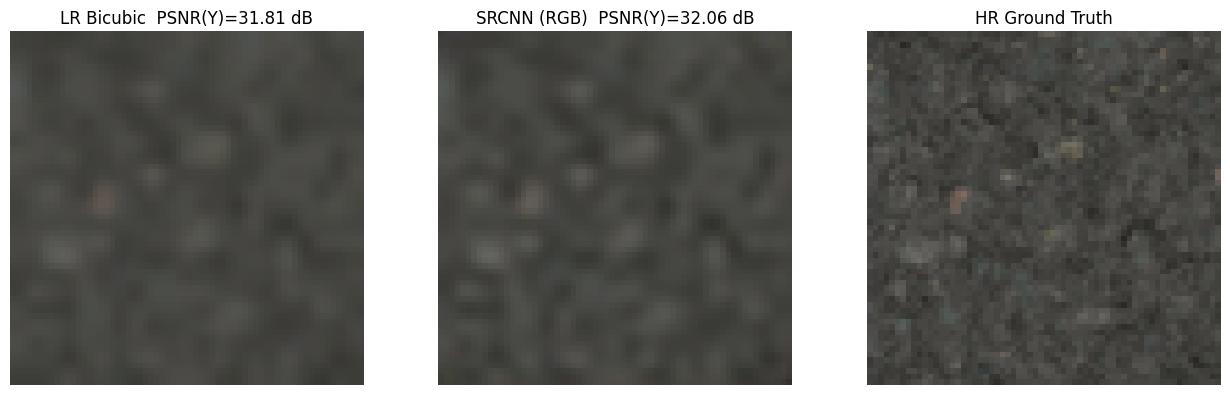

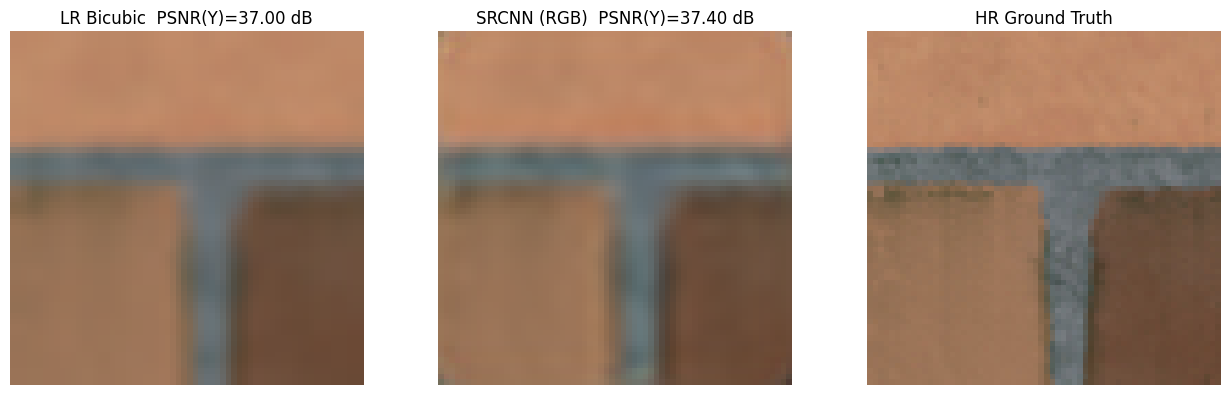

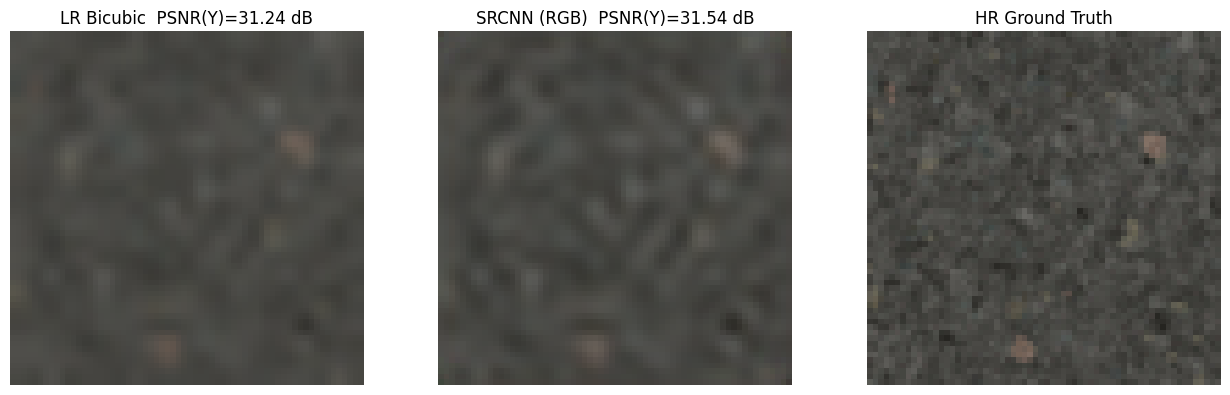

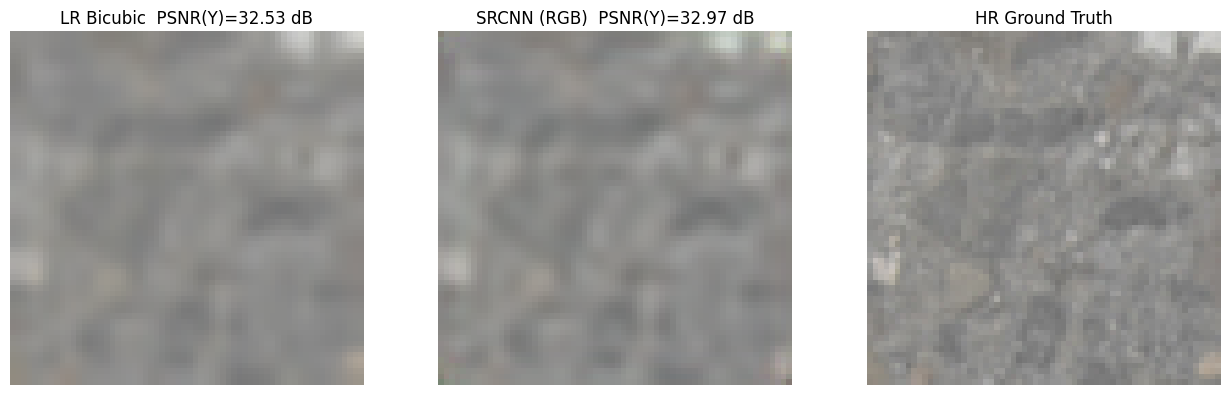

In [11]:
def to_hwc_np(t: torch.Tensor):
    """[C,H,W] float in [0,1] -> HxW(c) numpy for imshow."""
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 3 and t.shape[0] == 3:
        return np.transpose(t.numpy(), (1, 2, 0))
    return t.squeeze(0).numpy()

def psnr(a: torch.Tensor, b: torch.Tensor, eps=1e-10):
    # a,b: [C,H,W] in [0,1]
    mse = torch.mean((a - b) ** 2).item()
    return 20 * np.log10(1.0 / math.sqrt(mse + eps))

def rgb_to_y(t: torch.Tensor) -> torch.Tensor:
    """[C,H,W] RGB in [0,1] -> [1,H,W] Y (BT.601)."""
    if t.shape[0] == 1:
        return t
    r, g, b = t[0], t[1], t[2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    return y.unsqueeze(0)

def rgb_to_ycbcr(t: torch.Tensor):
    """[C,H,W] RGB in [0,1] -> (Y,Cb,Cr) each [1,H,W], BT.601 with 0.5 offset for Cb/Cr."""
    r, g, b = t[0], t[1], t[2]
    Y  = 0.299  * r + 0.587  * g + 0.114  * b
    Cb = -0.168736 * r - 0.331264 * g + 0.5      * b + 0.5
    Cr =  0.5      * r - 0.418688 * g - 0.081312 * b + 0.5
    return Y.unsqueeze(0), Cb.unsqueeze(0), Cr.unsqueeze(0)

def ycbcr_to_rgb(Y: torch.Tensor, Cb: torch.Tensor, Cr: torch.Tensor):
    """Y,Cb,Cr in [0,1] (Cb/Cr centered at 0.5) -> [3,H,W] RGB in [0,1]."""
    r = Y + 1.402   * (Cr - 0.5)
    g = Y - 0.344136 * (Cb - 0.5) - 0.714136 * (Cr - 0.5)
    b = Y + 1.772   * (Cb - 0.5)
    out = torch.stack([r, g, b], dim=0).clamp(0, 1)
    return out

model.eval()

# ---------- Pick random samples from the validation set ----------
NUM_SAMPLES = 4
rand_idxs = random.sample(range(len(train_dataset)), k=min(NUM_SAMPLES, len(train_dataset)))

for i, idx in enumerate(rand_idxs, 1):
    lr, hr = train_dataset[idx]   # [C,H,W] in [0,1]; LR is bicubic-upsampled to HR size

    # Match model channels
    if model.conv1.in_channels == 1:
        # Y-channel model
        if lr.shape[0] == 3:
            # Keep chroma from LR for colorizing the SR output
            Y_lr, Cb_lr, Cr_lr = rgb_to_ycbcr(lr)
            Y_hr = rgb_to_y(hr)
            lr_in = Y_lr.to(device)                     # [1,H,W]
            with torch.no_grad():
                sr_y = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)  # [1,H,W]
            # Recolor SR using LR chroma for display
            sr_rgb = ycbcr_to_rgb(sr_y, Cb_lr, Cr_lr)
            # For fair PSNR, compute on Y
            psnr_bic = psnr(Y_lr, Y_hr)
            psnr_sr  = psnr(sr_y, Y_hr)

            # What to show:
            img_lr = lr                    # color bicubic input (for context)
            img_sr = sr_rgb                # colorized SR
            img_hr = hr                    # GT color

            title_mid = f"SRCNN (Y only)  PSNR(Y)={psnr_sr:.2f} dB"
            title_left = f"LR Bicubic  PSNR(Y)={psnr_bic:.2f} dB"
        else:
            # Dataset already single-channel
            lr_in = lr.to(device)
            with torch.no_grad():
                sr = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)
            psnr_bic = psnr(lr, hr)
            psnr_sr  = psnr(sr, hr)
            img_lr, img_sr, img_hr = lr, sr, hr
            title_mid = f"SRCNN  PSNR={psnr_sr:.2f} dB"
            title_left = f"LR Bicubic  PSNR={psnr_bic:.2f} dB"
    else:
        # RGB model
        lr_in = lr.to(device)
        with torch.no_grad():
            sr = model(lr_in.unsqueeze(0)).squeeze(0).cpu().clamp(0,1)
        # PSNR on Y for fair comparison (common in SR)
        psnr_bic = psnr(rgb_to_y(lr), rgb_to_y(hr))
        psnr_sr  = psnr(rgb_to_y(sr), rgb_to_y(hr))
        img_lr, img_sr, img_hr = lr, sr, hr
        title_mid = f"SRCNN (RGB)  PSNR(Y)={psnr_sr:.2f} dB"
        title_left = f"LR Bicubic  PSNR(Y)={psnr_bic:.2f} dB"

    # ---------- Plot ----------
    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    axes[0].imshow(to_hwc_np(img_lr))
    axes[0].set_title(title_left)
    axes[0].axis("off")

    axes[1].imshow(to_hwc_np(img_sr))
    axes[1].set_title(title_mid)
    axes[1].axis("off")

    axes[2].imshow(to_hwc_np(img_hr))
    axes[2].set_title("HR Ground Truth")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()